In [42]:
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
from TrackSelectorDNN.models.track_classifier import TrackClassifier
from TrackSelectorDNN.data_manager.dataset_factory import get_dataset
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from scipy.stats import binomtest
import numpy as np
from torch.utils.data import DataLoader
import shap

Manually look for the best model

In [43]:
run_root = "/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/"
best_val = float("inf")
best_ckpt_path = None
best_config = None

for trial_name in os.listdir(run_root):
    trial_dir = os.path.join(run_root, trial_name)
    metrics_file = os.path.join(trial_dir, "best_metrics.json")
    ckpt_file = os.path.join(trial_dir, "best_model.pt")

    if os.path.exists(metrics_file):
        with open(metrics_file, "r") as f:
            metrics = json.load(f)
        if metrics["val_loss"] < best_val:
            best_metrics = metrics
            best_val = metrics["val_loss"]
            best_ckpt_path = ckpt_file
            # optionally save config
            config_file = os.path.join(trial_dir, "config.yaml")
            best_config = config_file if os.path.exists(config_file) else None

print("Best checkpoint:", best_ckpt_path)
print("Best val_loss:", best_val)
print("Best config file:", best_config)

Best checkpoint: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/6496f_00068/best_model.pt
Best val_loss: 0.14483716235184305
Best config file: /eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/6496f_00068/config.yaml


In [44]:
best_metrics

{'epoch': 26,
 'train_loss': 0.1465933497823777,
 'val_loss': 0.14483716235184305,
 'val_acc': 0.937718818380744}

In [45]:
import yaml

# Open and load YAML
with open(best_config, "r") as f:
    best_config = yaml.safe_load(f)

Load the validation dataset

In [46]:
#best_config["val_path"] = '/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/TrackSelectorDNN/data/10_tracks_train-val_dataset.pt'

In [47]:
val_ds, collate_fn = get_dataset(best_config, dataset_role="val_path")
device = "cpu" #"cuda" if torch.cuda.is_available() else
val_loader = DataLoader(val_ds, batch_size=best_config["batch_size"], collate_fn=collate_fn)

In [48]:
'''
val_ds.recHitFeatures = torch.cat(
    [val_ds.recHitFeatures,
     torch.zeros(len(val_ds.recHitFeatures), 16, 3)],
    dim=-1
)
'''
val_ds.recHitFeatures.shape

torch.Size([36560, 16, 9])

build the model

In [49]:
model = TrackClassifier(hit_input_dim = best_config["hit_input_dim"],
                        track_feat_dim = best_config["track_feat_dim"],
                        latent_dim = best_config["latent_dim"],
                        pooling_type = best_config["pooling_type"],
                        # --- NetA parameters ---
                        netA_hidden_dim = best_config["netA_hidden_dim"],
                        netA_hidden_layers = best_config["netA_hidden_layers"],
                        netA_batchnorm = best_config["netA_batchnorm"],
                        netA_activation = best_config["netA_activation"],
                        # --- NetB parameters ---
                        netB_hidden_dim = best_config["netB_hidden_dim"],
                        netB_hidden_layers = best_config["netB_hidden_layers"],
                        netB_batchnorm = best_config["netB_batchnorm"],
                        netB_activation = best_config["netB_activation"]).to(device)


model.load_state_dict(torch.load(best_ckpt_path, map_location=device))
model.eval()

TrackClassifier(
  (pool): SumPooling()
  (netA): NetA(
    (mlp): Sequential(
      (0): Linear(in_features=9, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_features=128, out_features=128, bias=True)
      (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01)
      (6): Linear(in_features=128, out_features=128, bias=True)
      (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): LeakyReLU(negative_slope=0.01)
      (9): Linear(in_features=128, out_features=8, bias=True)
    )
  )
  (netB): NetB(
    (mlp): Sequential(
      (0): Linear(in_features=33, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Linear(in_

In [50]:
def plot_run_losses(run_dir):
    log_file = os.path.join(run_dir, "metrics.csv")  # or whatever CSVLogger writes
    if not os.path.exists(log_file):
        raise FileNotFoundError(f"No metrics.csv found in {run_dir}")

    df = pd.read_csv(log_file)

    # Assumes columns: epoch, train_loss, val_loss
    epochs = df["epoch"]
    train_loss = df["train_loss"]
    val_loss = df["val_loss"]

    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")

    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    #plt.yscale('log')
    #plt.xscale('log')
    plt.show()


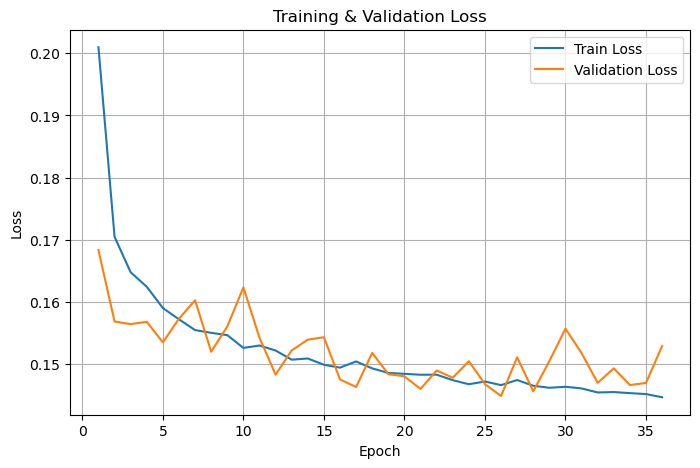

In [51]:
plot_run_losses("/eos/user/e/ecoradin/GitHub/TrackSelectorDNN/runs/6496f_00068/")

Rerun inference on validation

In [52]:
all_preds = []
all_labels = []
all_isHighPurity = []

with torch.no_grad():
    for batch in val_loader:
        hit_features = batch["hit_features"].to(device)
        track_features = batch["track_features"].to(device)
        mask = batch["mask"].to(device)
        
        preds = model(hit_features, track_features, mask).cpu().numpy()
        all_preds.append(preds)

    all_preds = np.concatenate(all_preds)
    

# Load the legacy classifier output from the dataset
all_isHighPurity = val_ds.isHighPurity.numpy()  
all_labels = val_ds.labels.numpy()  

In [53]:
# ROC curve
fpr_dnn, tpr_dnn, _ = roc_curve(all_labels, all_preds)
auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_hp, tpr_hp, _ = roc_curve(all_labels, all_isHighPurity)
auc_hp = auc(fpr_hp, tpr_hp)

# Accuracy and confusion matrix for DNN
preds_bin = (all_preds > 0.3).astype(int)
acc_dnn = accuracy_score(all_labels, preds_bin)
tn, fp, fn, tp = confusion_matrix(all_labels, preds_bin).ravel()

print(f"✅ DNN Results:")
print(f"  AUC: {auc_dnn:.4f}")
print(f"  Accuracy: {acc_dnn:.4f}")
print(f"  True Positives:  {tp}")
print(f"  False Positives: {fp}")
print(f"  True Negatives:  {tn}")
print(f"  False Negatives: {fn}")

✅ DNN Results:
  AUC: 0.9762
  Accuracy: 0.9281
  True Positives:  29839
  False Positives: 2250
  True Negatives:  4093
  False Negatives: 378


In [54]:
# Accuracy for legacy classifier
acc_hp = accuracy_score(all_labels, all_isHighPurity)
tn_hp, fp_hp, fn_hp, tp_hp = confusion_matrix(all_labels, all_isHighPurity).ravel()

print(f"\n✅ Legacy (isHighPurity) Results:")
print(f"  AUC: {auc_hp:.4f}")
print(f"  Accuracy: {acc_hp:.4f}")
print(f"  True Positives:  {tp_hp}")
print(f"  False Positives: {fp_hp}")
print(f"  True Negatives:  {tn_hp}")
print(f"  False Negatives: {fn_hp}")


✅ Legacy (isHighPurity) Results:
  AUC: 0.6610
  Accuracy: 0.8727
  True Positives:  29768
  False Positives: 4206
  True Negatives:  2137
  False Negatives: 449


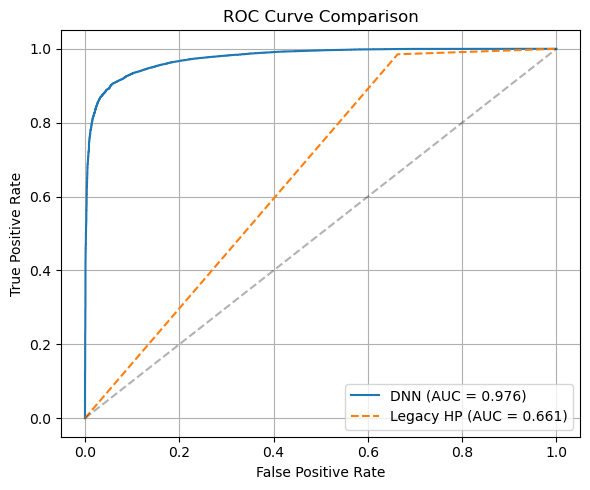

In [14]:
plt.figure(figsize=(6, 5))
plt.plot(fpr_dnn, tpr_dnn, label=f"DNN (AUC = {auc_dnn:.3f})")
plt.plot(fpr_hp, tpr_hp, label=f"Legacy HP (AUC = {auc_hp:.3f})", linestyle="--")
plt.plot([0, 1], [0, 1], "k--", alpha=0.3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

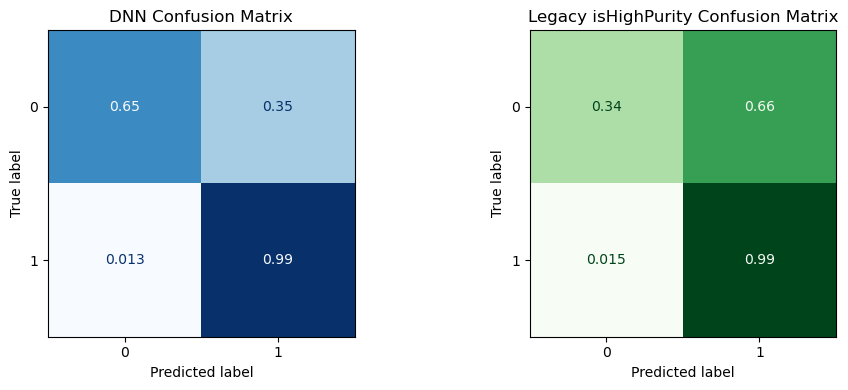

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

ConfusionMatrixDisplay(confusion_matrix(all_labels, preds_bin, normalize='true')).plot(
    ax=axes[0], cmap="Blues", colorbar=False
)
axes[0].set_title("DNN Confusion Matrix")

ConfusionMatrixDisplay(confusion_matrix(all_labels, all_isHighPurity, normalize='true')).plot(
    ax=axes[1], cmap="Greens", colorbar=False
)
axes[1].set_title("Legacy isHighPurity Confusion Matrix")

for ax in axes:
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

plt.tight_layout()
plt.show()

In [36]:
# Load previously exported binning
binning = np.loadtxt("/eos/user/e/ecoradin/sakura/examples/results/binning_fakeVsEta.txt", comments="#")

# Extract only the bin edges for compute_fake_rate
eta_bins = np.unique(np.concatenate([binning[:,0], binning[:,1]]))
eta_centers = 0.5 * (eta_bins[:-1] + eta_bins[1:])
external_fake = binning[:,2]
print("Loaded η bins:", eta_bins)

Loaded η bins: [-4.5 -4.4 -4.3 -4.2 -4.1 -4.  -3.9 -3.8 -3.7 -3.6 -3.5 -3.4 -3.3 -3.2
 -3.1 -3.  -2.9 -2.8 -2.7 -2.6 -2.5 -2.4 -2.3 -2.2 -2.1 -2.  -1.9 -1.8
 -1.7 -1.6 -1.5 -1.4 -1.3 -1.2 -1.1 -1.  -0.9 -0.8 -0.7 -0.6 -0.5 -0.4
 -0.3 -0.2 -0.1  0.   0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  1.
  1.1  1.2  1.3  1.4  1.5  1.6  1.7  1.8  1.9  2.   2.1  2.2  2.3  2.4
  2.5  2.6  2.7  2.8  2.9  3.   3.1  3.2  3.3  3.4  3.5  3.6  3.7  3.8
  3.9  4.   4.1  4.2  4.3  4.4  4.5]


In [37]:
external_fake

array([0.        , 0.        , 0.00337839, 0.00144655, 0.00181478,
       0.00123066, 0.00103575, 0.00172138, 0.00153148, 0.00252634,
       0.00396782, 0.00410759, 0.00459647, 0.00617576, 0.00671387,
       0.00828946, 0.00940132, 0.00982881, 0.00992364, 0.01561302,
       0.02221912, 0.02985007, 0.02329791, 0.0315305 , 0.04689378,
       0.07179993, 0.07368088, 0.05130631, 0.070485  , 0.06779659,
       0.06243515, 0.04582518, 0.04687071, 0.03229159, 0.02462363,
       0.01892048, 0.01648664, 0.01506948, 0.01329142, 0.01015973,
       0.00894243, 0.0066998 , 0.00617218, 0.00679338, 0.00661737,
       0.00670213, 0.00710183, 0.00751764, 0.00713611, 0.00868291,
       0.01037943, 0.01243329, 0.01583582, 0.01892018, 0.01984996,
       0.02401936, 0.03209144, 0.04235154, 0.04642892, 0.06157708,
       0.06565511, 0.07481879, 0.07096565, 0.09221864, 0.08189577,
       0.04666638, 0.03486693, 0.02074248, 0.02998149, 0.02458942,
       0.01525849, 0.00859076, 0.01033467, 0.0112375 , 0.00729

In [34]:
def compute_fake_rate(y_true, y_pred_bin, eta, bins, cl=0.683):
    nbins = len(bins) - 1
    fake_rate = np.full(nbins, np.nan)
    fake_err_low = np.full(nbins, np.nan)
    fake_err_up  = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (eta >= bins[i]) & (eta < bins[i+1])
        if sel.sum() == 0:
            continue

        predicted_real = (y_pred_bin[sel] == 1)
        #print(predicted_real.shape, predicted_real.sum(), y_true[sel].sum())
        total = predicted_real.sum()
        if total == 0:
            continue

        fake = ((y_true[sel] == 0) & predicted_real).sum()

        # central value
        p = fake / total
        fake_rate[i] = p

        # binomial confidence interval
        result = binomtest(fake, total)
        ci = result.proportion_ci(confidence_level=cl)

        fake_err_low[i] = p - ci.low
        fake_err_up[i]  = ci.high - p
    
    return fake_rate, fake_err_low, fake_err_up

def compute_efficiency(y_true, y_pred_bin, eta, bins, cl=0.683):
    nbins = len(bins) - 1
    eff = np.full(nbins, np.nan)
    eff_err_low = np.full(nbins, np.nan)
    eff_err_up  = np.full(nbins, np.nan)

    for i in range(nbins):
        sel = (eta >= bins[i]) & (eta < bins[i+1])

        true_sel = sel & (y_true == 1)
        total = true_sel.sum()
        if total == 0:
            continue

        passed = (y_pred_bin[true_sel] == 1).sum()

        # central value
        p = passed / total
        eff[i] = p

        # binomial confidence interval
        result = binomtest(passed, total)
        ci = result.proportion_ci(confidence_level=cl)

        eff_err_low[i] = p - ci.low
        eff_err_up[i]  = ci.high - p

    return eff, eff_err_low, eff_err_up

# --- Recover raw η ---
eta_idx = val_ds.recoPixelTrackBranches.index("hltPixelTrack_eta")

eta_norm = val_ds.recoPixelTrackFeatures[:, eta_idx].numpy()
eta_mean = val_ds.recoPixelTrack_mean[0, eta_idx].numpy()
eta_std  = val_ds.recoPixelTrack_std[0, eta_idx].numpy()

eta_vals = eta_norm * eta_std + eta_mean   # <-- raw η

# --- Threshold predictions ---
preds_bin = (all_preds > 0.35).astype(int)
labels = all_labels.astype(int)
hp = all_isHighPurity.astype(int)

# --- Binomial CI fake rates ---
print('---- DNN ') 
fake_rate_dnn, fake_low_dnn, fake_up_dnn = compute_fake_rate(labels, preds_bin, eta_vals, eta_bins)
print('---- HP ')
fake_rate_hp,  fake_low_hp,  fake_up_hp  = compute_fake_rate(labels, hp,       eta_vals, eta_bins)
print('---- Worst ')
fake_rate_worst,  fake_low_worst,  fake_up_worst  = compute_fake_rate(labels, np.ones_like(labels),       eta_vals, eta_bins)

# --- Binomial CI efficiency ---
eff_dnn, eff_low_dnn, eff_up_dnn = compute_efficiency(labels, preds_bin, eta_vals, eta_bins)
eff_hp,  eff_low_hp,  eff_up_hp  = compute_efficiency(labels, hp,       eta_vals, eta_bins)


---- DNN 
---- HP 
---- Worst 


In [32]:
val_ds.recoPixelTrack_mean.shape

torch.Size([1, 25])

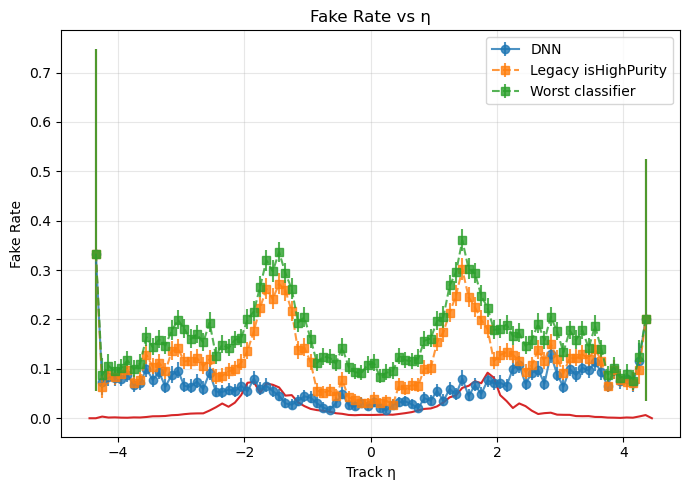

In [56]:
# --- Plot Fake Rate ---
plt.figure(figsize=(7,5))
plt.errorbar(
    eta_centers, fake_rate_dnn,
    yerr=[fake_low_dnn, fake_up_dnn],
    fmt='o-', label='DNN', alpha=0.8
)

plt.errorbar(
    eta_centers, fake_rate_hp,
    yerr=[fake_low_hp, fake_up_hp],
    fmt='s--', label='Legacy isHighPurity', alpha=0.8
)
plt.errorbar(
    eta_centers, fake_rate_worst,
    yerr=[fake_low_worst, fake_up_worst],
    fmt='s--', label='Worst classifier', alpha=0.8
)
plt.plot(eta_centers, external_fake)
plt.xlabel('Track η')
plt.ylabel('Fake Rate')
plt.title('Fake Rate vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

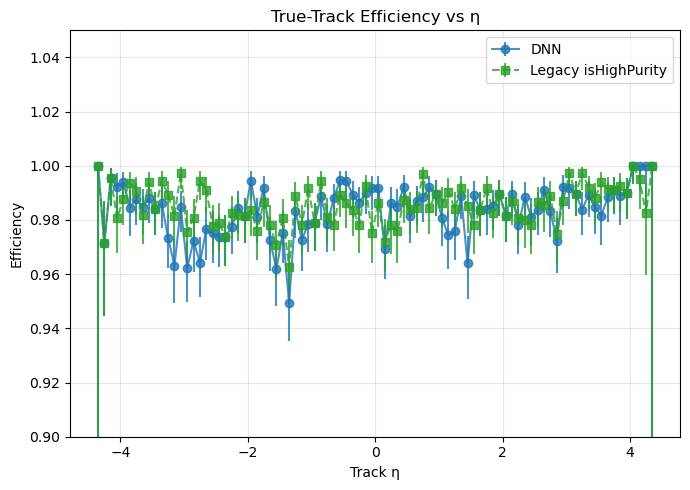

In [20]:
# --- Plot Efficiency ---
plt.figure(figsize=(7,5))
plt.errorbar(
    eta_centers, eff_dnn,
    yerr=[eff_low_dnn, eff_up_dnn],
    fmt='o-', label='DNN', color='tab:blue', alpha=0.8
)
plt.errorbar(
    eta_centers, eff_hp,
    yerr=[eff_low_hp, eff_up_hp],
    fmt='s--', label='Legacy isHighPurity', color='tab:green', alpha=0.8
)
plt.xlabel('Track η')
plt.ylabel('Efficiency')
plt.title('True-Track Efficiency vs η')
plt.grid(True, alpha=0.3)
plt.legend()
plt.ylim(0.9, 1.05)
plt.tight_layout()
plt.show()

In [21]:
from sklearn.metrics import confusion_matrix

tn_hp, fp_hp, fn_hp, tp_hp = confusion_matrix(all_labels, hp).ravel()
tpr_hp = tp_hp / (tp_hp + fn_hp)

print("Legacy TPR:", tpr_hp)
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
idx = np.argmin(np.abs(tpr - tpr_hp))

best_threshold = thresholds[idx]
tpr_dnn_at_best = tpr[idx]
fpr_dnn_at_best = fpr[idx]

print("Best DNN threshold:", best_threshold)
print("DNN TPR at matched point:", tpr_dnn_at_best)
print("DNN FPR at matched point:", fpr_dnn_at_best)

Legacy TPR: 0.985140814773141
Best DNN threshold: 0.32732752
DNN TPR at matched point: 0.9851077208194063
DNN FPR at matched point: 0.33312312785748066
